In [1]:
import time

import pandas as pd
import torch
from torch import Tensor
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()


def closure():
        optimizer.zero_grad()
        y_hat = model.forward(X_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        return loss
    
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

import numpy as np
from sklearn.model_selection import GridSearchCV

from copy import deepcopy

data = pd.read_csv('Proj1ReorderedRound.csv')

import warnings
warnings.filterwarnings('ignore')

In [2]:
X = data.drop('Condition', axis=1).values
y = data['Condition'].values

y = LE.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = stdscaler.fit_transform(X_train)
X_test = stdscaler.transform(X_test)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [3]:
class ANN(nn.Module):
    def __init__(self,solver):
        super().__init__()
        
        if (solver == 'SGD'):
            self.fc1 = nn.Linear(in_features = 12, out_features = 8)
            self.output = nn.Linear(in_features=8, out_features=3)
            
        if (solver == 'LBFGS'):
            self.fc1 = nn.Linear(in_features = 12, out_features = 11)
            self.fc2 = nn.Linear(in_features = 11, out_features = 9)
            self.output = nn.Linear(in_features=9, out_features=3)
        
        if (solver == 'Adam'):
            self.fc1 = nn.Linear(in_features = 12, out_features = 8)
            self.fc2 = nn.Linear(in_features = 8, out_features = 4)
            self.fc3 = nn.Linear(in_features = 4, out_features = 10)
            self.output = nn.Linear(in_features=10, out_features=3)
            
        if (solver == 'Adamf'):
            self.fc1 = nn.Linear(in_features = 2, out_features = 8)
            self.fc2 = nn.Linear(in_features = 8, out_features = 4)
            self.fc3 = nn.Linear(in_features = 4, out_features = 10)
            self.output = nn.Linear(in_features=10, out_features=3)
        
        self.solver = solver
 
    def forward(self, x):
        
        if (solver == 'SGD'):
            x = F.selu(self.fc1(x))
            x = self.output(x)
            
        if (solver == 'LBFGS'):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
        
        if (solver == 'Adam'):
            x = F.selu(self.fc1(x))
            x = F.selu(self.fc2(x))
            x = F.selu(self.fc3(x))
            x = self.output(x)
            
        if (solver == 'Adamf'):
            x = F.selu(self.fc1(x))
            x = F.selu(self.fc2(x))
            x = F.selu(self.fc3(x))
            x = self.output(x)
        
        return x
    
criterion = nn.CrossEntropyLoss()

In [4]:
initiator = 0

solver = 'Adam'

if (solver == 'Adam'):
    af = 'selu'
    layers = 3
    
if (solver == 'Adamf'):
    af = 'selu'
    layers = 3

if (solver == 'LBFGS'):
    af = 'relu'
    layers = 2
    
if (solver == 'SGD'):
    af = 'selu'
    layers = 1
    


In [5]:
Abase = 1

Range = []
stage = 1

for i in range(-10,11):
    x = np.round(Abase + i*(10**(-stage)),stage)
    if (x>0):
        Range.append(x)

Range

[0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0]

In [6]:
time_list = []
index = 0
I = 0
Abase = 1

LossDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

if (initiator == 0):   
    FML = []
    
for i in range(4):
    stage = i+1

    Range = []
    
    tempDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

    for i in range(-10,11):
        x = np.round(Abase + i*(10**(-stage)),stage)
        if (x>0):
            Range.append(x)
    
    for A in Range:
    
        if (initiator == 0):
            model = ANN(solver)
            dummy = deepcopy(model)
            FML.append(dummy)
            initiator = 1
        
        elif (initiator == 1):
            model = deepcopy(FML[0])
    
        Start = time.time()
        
        to_add = []
        to_add.append(A)
        
        epochs = 0
        
        if (solver == 'Adam'):
            optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
        if (solver == 'LBFGS'):
            optimizer = torch.optim.LBFGS(model.parameters(), lr=A) # LBFGS
        if (solver == 'SGD'):
            optimizer = torch.optim.SGD(model.parameters(), lr=A) # SGD
            
        loss = 1
        lossT = loss
        
        while (lossT > 0.0001):
            y_hat = model.forward(X_train)
            loss = criterion(y_hat, y_train)
            optimizer.zero_grad()
            loss.backward()
            
            if (solver == 'LBFGS'):
                optimizer.step(closure)
            
            else:
                optimizer.step()
                
            epochs += 1
            
            lossT = loss.detach().numpy()
            
            if (epochs == 1):
                to_add.append(lossT)
                
            if (epochs > 1000):
                lossT = 0
                
                
        to_add.append(loss.detach().numpy())
        to_add.append(epochs)
        
        tempDF.loc[index] = to_add
        index += 1
    
        End = time.time()
        dura = End - Start
        time_list.append(dura)
    
        print('\nComputation for learning rate = ',A,'complete')
        print('Time taken : ', np.round(dura,3),'s')
        
        Abase = tempDF.sort_values(by = 'final')['alpha'].iloc[0]
    
    LossDF.loc[I] = tempDF.sort_values(by = 'epoch to converge').iloc[0]
    I += 1

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')

alphaList = LossDF['alpha']

LossDF


Computation for learning rate =  0.1 complete
Time taken :  0.033 s

Computation for learning rate =  0.2 complete
Time taken :  0.052 s

Computation for learning rate =  0.3 complete
Time taken :  0.047 s

Computation for learning rate =  0.4 complete
Time taken :  1.091 s

Computation for learning rate =  0.5 complete
Time taken :  1.087 s

Computation for learning rate =  0.6 complete
Time taken :  1.097 s

Computation for learning rate =  0.7 complete
Time taken :  1.062 s

Computation for learning rate =  0.8 complete
Time taken :  1.058 s

Computation for learning rate =  0.9 complete
Time taken :  1.071 s

Computation for learning rate =  1.0 complete
Time taken :  1.122 s

Computation for learning rate =  1.1 complete
Time taken :  1.113 s

Computation for learning rate =  1.2 complete
Time taken :  1.133 s

Computation for learning rate =  1.3 complete
Time taken :  1.22 s

Computation for learning rate =  1.4 complete
Time taken :  1.163 s

Computation for learning rate =  1

,alpha,initial,final,epoch to converge
0,0.1000,1.0590307,8.144784e-05,30
1,0.2500,1.0590307,5.422152e-05,31
2,0.3050,1.0590307,9.935582e-05,23
3,0.3148,1.0590307,1.0407864e-06,24



Computation for learning rate =  0.1 complete
Time taken :  0.032 s

Computation for learning rate =  0.25 complete
Time taken :  0.036 s

Computation for learning rate =  0.305 complete
Time taken :  0.025 s

Computation for learning rate =  0.3148 complete
Time taken :  0.026 s

Solver :  Adam
Activation function :  selu

Total time taken : 0.119 s


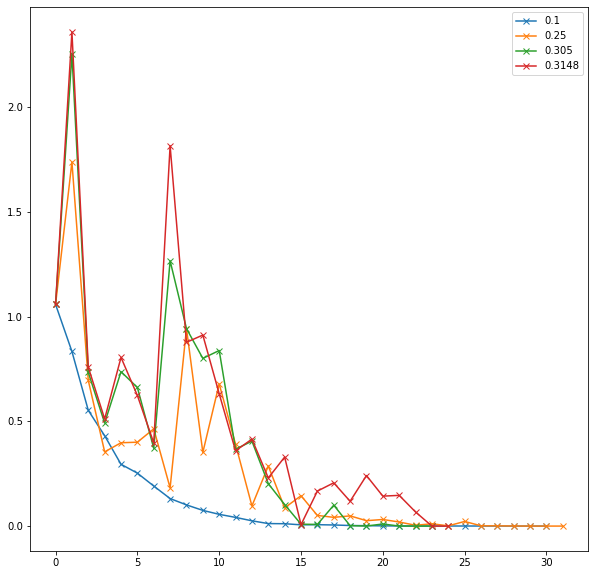

In [7]:
lossList = []

modelList = []

time_list = []

if (initiator == 0):   
    FML = []
    
for A in alphaList:
    
    if (initiator == 0):
        model = ANN(solver)
        dummy = deepcopy(model)
        FML.append(dummy)
        initiator = 1
        
    elif (initiator == 1):
        model = deepcopy(FML[0])
    
    Start = time.time()
        
    to_add = []
        
    if (solver == 'Adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
    if (solver == 'LBFGS'):
        optimizer = torch.optim.LBFGS(model.parameters(), lr=A) # LBFGS
    if (solver == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=A) # SGD
            
    loss = 1
    lossT = loss
        
    while (lossT > 0.0001):
        y_hat = model.forward(X_train)
        loss = criterion(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
            
        if (solver == 'LBFGS'):
            optimizer.step(closure)
            
        else:
            optimizer.step()
                     
        to_add.append(loss.detach().numpy())
        
        lossT = loss.detach().numpy()
        
    to_add.append(loss.detach().numpy())
    
    End = time.time()
    dura = End - Start
    time_list.append(dura)
    
    print('\nComputation for learning rate = ',A,'complete')
    print('Time taken : ', np.round(dura,3),'s')
    
    lossList.append(to_add)
    
    modelList.append(model)

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')

plt.figure(figsize = (10,10)) 

for line in lossList:
    plt.plot(line,'-x')
    
plt.legend(alphaList)

In [8]:
list(modelList[-1].parameters()) #best model weight and bias

[Parameter containing:
 tensor([[-0.2355,  0.3157, -0.1732,  1.0635,  1.1549, -1.5587,  1.1132, -0.8550,
           0.4253,  0.8050, -0.8063, -0.9900],
         [ 1.2064,  1.6291,  3.4604,  2.2985,  1.7419, -2.3913,  1.2599,  2.9868,
           1.1470, -1.0103, -0.2208,  0.2538],
         [ 1.0807,  1.1151,  0.0435, -0.0841, -0.4218,  0.7815,  1.6668,  1.1306,
           0.2998, -0.9432, -2.9920, -3.5817],
         [ 0.0870,  0.9135,  1.3610, -0.6700, -0.7364,  1.0046, -0.0753,  0.5676,
           0.4297, -1.1750, -0.0491,  0.0888],
         [-0.6546, -0.4182,  1.6135,  0.0557,  1.2842, -1.3479,  0.8217, -0.5615,
           0.4412, -1.9344, -1.8091, -3.3255],
         [ 0.7520,  0.2480, -1.3171, -0.1427, -0.3539,  0.3584, -0.0179,  1.0239,
           0.4964, -0.1126, -2.4961, -3.4271],
         [-0.9525, -2.2184, -1.3268,  1.1959,  0.4388,  0.5478, -0.4133, -1.7581,
          -0.7778,  1.2110,  0.3560, -0.1389],
         [ 1.6404,  1.0316, -0.1398,  0.4185, -0.3755, -0.2390,  1.0318,  

In [9]:
print('Input variable weights to first hidden layer nodes')
pd.DataFrame(modelList[2].fc1.weight.detach().numpy(), columns = data.drop('Condition', axis=1).columns,index = range(1,9))

Input variable weights to first hidden layer nodes


,Cylinder heating zone 1,Cylinder heating zone 2,Cylinder heating zone 3,Cylinder heating zone 4,Cylinder heating zone 5,Mould temperature control unit 1,Maximum injection pressure,Cycle time,Injection time,Dosage time,Switch-over volume,Material cushion
1,-0.174774,0.118662,0.220553,1.295238,1.512533,-1.286501,0.946872,-0.221013,0.807958,0.210900,-1.081052,-0.813742
2,1.070757,1.421133,3.094010,2.125256,1.503735,-2.591135,0.843283,2.349562,1.115212,-0.951725,-0.355550,-0.104985
3,1.435221,1.007465,-0.443473,0.637005,0.135935,0.911968,1.427279,1.304967,0.195839,-1.458152,-2.659379,-2.725483
4,0.899139,1.392220,2.073002,-0.020093,0.089518,0.613513,-0.093950,0.660481,-0.679818,-0.674564,0.006033,0.557639
5,-1.181975,-0.436994,1.900367,0.229673,1.239897,-0.797770,0.825983,-0.370795,0.525143,-1.829005,-1.984739,-2.877878
6,0.672964,0.427637,-1.036407,-0.594197,-0.442839,0.253749,-0.094786,0.529688,0.278451,0.251343,-2.514743,-2.784666
7,-0.445838,-1.635377,-1.158484,1.272176,-0.325273,1.384572,-0.702933,-1.968501,-0.877048,1.235175,0.288798,-0.116384
8,0.683683,0.022429,-0.719766,-0.527467,-0.068858,-0.649593,1.042773,-0.039433,1.784692,-0.719848,-1.919783,-2.220441


In [10]:
print('Average absolute weight contributions of each variable')
weightList = pd.DataFrame(modelList[2].fc1.weight.detach().numpy(), columns = data.drop('Condition', axis=1).columns).mean().abs()

weightList

Average absolute weight contributions of each variable


Cylinder heating zone 1             0.369897
Cylinder heating zone 2             0.289647
Cylinder heating zone 3             0.491225
Cylinder heating zone 4             0.552199
Cylinder heating zone 5             0.455581
Mould temperature control unit 1    0.270150
Maximum injection pressure          0.524315
Cycle time                          0.280619
Injection time                      0.393804
Dosage time                         0.491985
Switch-over volume                  1.277552
Material cushion                    1.385742
dtype: float32

In [11]:
weightList = weightList.sort_values(ascending = False)

totalweight = weightList.sum()

weightList = weightList/totalweight

weightList   #sorted by percentage

Material cushion                    0.204305
Switch-over volume                  0.188354
Cylinder heating zone 4             0.081413
Maximum injection pressure          0.077302
Dosage time                         0.072535
Cylinder heating zone 3             0.072423
Cylinder heating zone 5             0.067168
Injection time                      0.058060
Cylinder heating zone 1             0.054535
Cylinder heating zone 2             0.042704
Cycle time                          0.041373
Mould temperature control unit 1    0.039829
dtype: float32

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

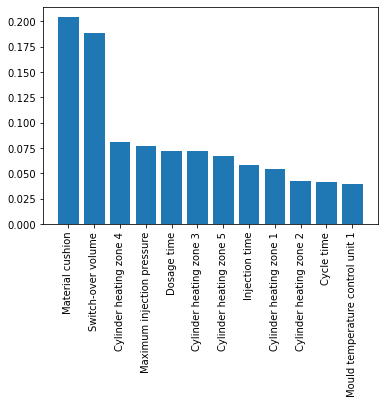

In [12]:
plt.bar(weightList.index,height = weightList)
plt.xticks(rotation = 90)

In [13]:
number = 2
selected_features = weightList.index[:number]

selected_features 

Index(['Material cushion', 'Switch-over volume'], dtype='object')

In [14]:
selected_features = ['Material cushion','Switch-over volume']

In [15]:
Xf = data[selected_features].values
y = data['Condition'].values

y = LE.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(Xf, y, test_size=0.2, random_state=0)
X_train = stdscaler.fit_transform(X_train)
X_test = stdscaler.transform(X_test)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

initiator = 0
solver = 'Adamf'

In [16]:
time_list = []
index = 0
I = 0
Abase = 1

LossDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

if (initiator == 0):   
    FML = []
    
for i in range(4):
    stage = i+1

    Range = []
    
    tempDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

    for i in range(-10,11):
        x = np.round(Abase + i*(10**(-stage)),stage)
        if (x>0):
            Range.append(x)
    
    for A in Range:
    
        if (initiator == 0):
            model = ANN('Adamf')
            dummy = deepcopy(model)
            FML.append(dummy)
            initiator = 1
        
        elif (initiator == 1):
            model = deepcopy(FML[0])
    
        Start = time.time()
        
        to_add = []
        to_add.append(A)
        
        epochs = 0
        
        optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
     
        loss = 1
        lossT = loss
        
        while (lossT > 0.0001):
            y_hat = model.forward(X_train)
            loss = criterion(y_hat, y_train)
            optimizer.zero_grad()
            loss.backward()
            
            if (solver == 'LBFGS'):
                optimizer.step(closure)
            
            else:
                optimizer.step()
                
            epochs += 1
            
            lossT = loss.detach().numpy()
            
            if (epochs == 1):
                to_add.append(lossT)
                
            if (epochs > 1000):
                lossT = 0
                
                
        to_add.append(loss.detach().numpy())
        to_add.append(epochs)
        
        tempDF.loc[index] = to_add
        index += 1
    
        End = time.time()
        dura = End - Start
        time_list.append(dura)
    
        print('\nComputation for learning rate = ',A,'complete')
        print('Time taken : ', np.round(dura,3),'s')
        
        Abase = tempDF.sort_values(by = 'final')['alpha'].iloc[0]
    
    LossDF.loc[I] = tempDF.sort_values(by = 'epoch to converge').iloc[0]
    I += 1

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')

alphaList = LossDF['alpha']

LossDF


Computation for learning rate =  0.1 complete
Time taken :  0.23 s

Computation for learning rate =  0.2 complete
Time taken :  0.205 s

Computation for learning rate =  0.3 complete
Time taken :  0.264 s

Computation for learning rate =  0.4 complete
Time taken :  0.177 s

Computation for learning rate =  0.5 complete
Time taken :  0.067 s

Computation for learning rate =  0.6 complete
Time taken :  0.4 s

Computation for learning rate =  0.7 complete
Time taken :  1.127 s

Computation for learning rate =  0.8 complete
Time taken :  1.109 s

Computation for learning rate =  0.9 complete
Time taken :  1.092 s

Computation for learning rate =  1.0 complete
Time taken :  1.144 s

Computation for learning rate =  1.1 complete
Time taken :  1.144 s

Computation for learning rate =  1.2 complete
Time taken :  1.181 s

Computation for learning rate =  1.3 complete
Time taken :  1.121 s

Computation for learning rate =  1.4 complete
Time taken :  1.111 s

Computation for learning rate =  1.5

,alpha,initial,final,epoch to converge
0,0.500,1.2510171,9.767901e-05,66
1,0.440,1.2510171,5.386785e-05,57
2,0.424,1.2510171,5.746639e-05,54
3,0.420,1.2510171,1.337617e-06,69



Computation for learning rate =  0.5 complete
Time taken :  0.066 s

Computation for learning rate =  0.44 complete
Time taken :  0.068 s

Computation for learning rate =  0.424 complete
Time taken :  0.06 s

Computation for learning rate =  0.42 complete
Time taken :  0.066 s

Solver :  Adamf
Activation function :  selu

Total time taken : 0.259 s


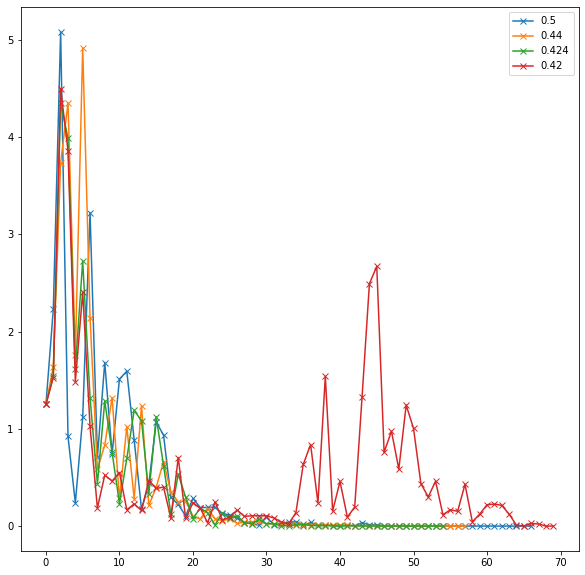

In [17]:
lossList = []

modelList = []

time_list = []

if (initiator == 0):   
    FML = []
    
for A in alphaList:
    
    if (initiator == 0):
        model = ANN('Adamf')
        dummy = deepcopy(model)
        FML.append(dummy)
        initiator = 1
        
    elif (initiator == 1):
        model = deepcopy(FML[0])
    
    Start = time.time()
        
    to_add = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
            
    loss = 1
    lossT = loss
        
    while (lossT > 0.0001):
        y_hat = model.forward(X_train)
        loss = criterion(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
            
        optimizer.step()
                     
        to_add.append(loss.detach().numpy())
        
        lossT = loss.detach().numpy()
        
    to_add.append(loss.detach().numpy())
    
    End = time.time()
    dura = End - Start
    time_list.append(dura)
    
    print('\nComputation for learning rate = ',A,'complete')
    print('Time taken : ', np.round(dura,3),'s')
    
    lossList.append(to_add)
    
    modelList.append(model)

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')

plt.figure(figsize = (10,10)) 

for line in lossList:
    plt.plot(line,'-x')
    
plt.legend(alphaList)

In [20]:
loss.detach().numpy()

array(1.0387281, dtype=float32)